# Autorki:
- Iza Danielewska
- Patrycja Żak

## Projekt nr 2 z przedmiotu Automatyczne Uczenie Maszynowe

Instalacja pakietu do wykorzystania Bayes Search

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 802.1 kB/s eta 0:00:00


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.6 MB/s eta 0:00:00


Instalacja pakietów użytych do automatycznego uczenia maszynowego

In [ ]:
!pip uninstall -y mkl
!pip install -U pip
!pip install -U "mxnet<2.0.0"
!pip install autogluon
!pip install -U ipykernel

!pip uninstall -y autogluon.core
!pip uninstall -y autogluon
!pip install autogluon
# po instalacji trzeba zrestartować środowisko

Found existing installation: mkl 2023.2.0
Uninstalling mkl-2023.2.0:
  Successfully uninstalled mkl-2023.2.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 7.

Wczytanie wykorzystywanych paczek

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge, LassoCV
import numpy as np
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc as sklearn_auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from autogluon.tabular import TabularPredictor
from sklearn.decomposition import PCA
from sklearn.metrics import balanced_accuracy_score
import shap

Wczytanie plików danych do Google Colab

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving artificial_test.data to artificial_test.data
Saving artificial_train.data to artificial_train.data
Saving artificial_train.labels to artificial_train.labels


In [ ]:
# reading csv files
data_train =  pd.read_csv('artificial_train.data', sep=" ",header = None)
print(data_train)
data_test = pd.read_csv('artificial_test.data', sep=" ",header = None).iloc[:,:-1]
label_train = pd.read_csv('artificial_train.labels', sep=" ",header = None)
print(label_train)
print(data_test)

      0    1    2    3    4    5    6    7    8    9    ...  491  492  493  \
0     485  477  537  479  452  471  491  476  475  473  ...  481  477  485   
1     483  458  460  487  587  475  526  479  485  469  ...  478  487  338   
2     487  542  499  468  448  471  442  478  480  477  ...  481  492  650   
3     480  491  510  485  495  472  417  474  502  476  ...  480  474  572   
4     484  502  528  489  466  481  402  478  487  468  ...  479  452  435   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1995  490  505  503  474  463  461  519  476  518  467  ...  479  449  588   
1996  480  475  476  480  495  482  515  479  480  484  ...  474  473  424   
1997  480  517  631  470  485  474  535  476  493  466  ...  483  479  687   
1998  484  481  505  478  542  477  518  477  510  472  ...  483  526  750   
1999  474  493  469  486  521  475  494  479  481  473  ...  476  508  449   

      494  495  496  497  498  499  500  
0     511  485  481  

Podział zbioru danych na zmienne objaśnijące (X) i zmienną objaśnianą (y)

In [ ]:
data_train.iloc[:,-1] = label_train
data_train.columns = data_train.columns.astype('str')
data_test.columns = data_test.columns.astype('str')
X_test =  data_test.loc[:, data_test.columns != "500"]
X, y = data_train.loc[:, data_train.columns != "500"], data_train["500"]
# zmiana etykiet z {-1,1} na {0,1} ze względu na wymagania w pakiecie xgboost
y = (y+1)/2

<ipython-input-4-07bb5634cde9>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_train.iloc[:,-1] = label_train


Podział danych na zbiór treningowy i walidacyjny w celu wewnętrznego sprawdzania otrzymywanych wyników.

Uwzględniono stratyfikację w celu równomiernego podziału etykiet.

In [ ]:
data_train.iloc[:,-1] = label_train
data_train.columns = data_train.columns.astype('str')
data_test.columns = data_test.columns.astype('str')

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.9, test_size = 0.1, stratify=y, random_state=3927)

Opis danych.

In [ ]:
print(data_train.shape)
print(data_train.head())
print(data_train.describe())

(2000, 501)
     0    1    2    3    4    5    6    7    8    9  ...  491  492  493  494  \
0  485  477  537  479  452  471  491  476  475  473  ...  481  477  485  511   
1  483  458  460  487  587  475  526  479  485  469  ...  478  487  338  513   
2  487  542  499  468  448  471  442  478  480  477  ...  481  492  650  506   
3  480  491  510  485  495  472  417  474  502  476  ...  480  474  572  454   
4  484  502  528  489  466  481  402  478  487  468  ...  479  452  435  486   

   495  496  497  498  499  500  
0  485  481  479  475  496   -1  
1  486  483  492  510  517   -1  
2  501  480  489  499  498   -1  
3  469  475  482  494  461    1  
4  508  481  504  495  511    1  

[5 rows x 501 columns]
                 0            1            2            3            4  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean    481.722500   483.452500   510.166000   483.384500   501.612500   
std       6.421769    30.186294    38.899165     9.059895

In [ ]:
label = '500'
print("Summary of class variable: \n", data_train[label].describe)

Summary of class variable: 
 <bound method NDFrame.describe of 0      -1
1      -1
2      -1
3       1
4       1
       ..
1995    1
1996   -1
1997   -1
1998    1
1999    1
Name: 500, Length: 2000, dtype: int64>


# Model z użyciem frameworka AutoMLowego

Wykonanie głównego kodu

In [ ]:
save_path = 'agModels-predictClass'
predictor = TabularPredictor(label=label, path=save_path, problem_type='binary', eval_metric='balanced_accuracy').fit(data_train, presets='best_quality')

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 3600 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: agModels-predictClass/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "agModels-predictClass/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1

Wynik BA uzyskany dla modelu AutoMLowym na zbiorze treningowym.

In [ ]:
performance = predictor.evaluate(data_train)
print(performance)

{'balanced_accuracy': 0.9515, 'accuracy': 0.9515, 'mcc': 0.9030040635274288, 'roc_auc': 0.9930450000000001, 'f1': 0.9514271407110665, 'precision': 0.9528585757271816, 'recall': 0.95}


Podsumowanie modelu AutoMLowego i predykcja na zbiorze testowym


In [ ]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val        eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0               CatBoost_BAG_L1     0.8670  balanced_accuracy       0.202050  310.605922                0.202050         310.605922            1       True          7
1           WeightedEnsemble_L2     0.8670  balanced_accuracy       0.207034  314.595555                0.004984           3.989633            2       True         21
2          CatBoost_r177_BAG_L1     0.8645  balanced_accuracy       0.201361  299.576621                0.201361         299.576621            1       True         14
3          LightGBM_r131_BAG_L1     0.8520  balanced_accuracy       0.081690  139.102805                0.081690         139.102805            1       True         16
4          LightGBMLarge_BAG_L1     0.8450  balanced_accuracy       0.083043  332.826272               

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestGini_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForestEntr_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesGini_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTreesEntr_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'NeuralNetTorch_r79_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBM_r131_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetFastAI_r191_BAG_L1': 'StackerEnsembleModel_NNFastAiT

In [ ]:
predictor.predict(data_test)

0     -1.0
1     -1.0
2     -1.0
3      1.0
4     -1.0
      ... 
595    1.0
596   -1.0
597    1.0
598    1.0
599   -1.0
Name: 500, Length: 600, dtype: float64

Zapisanie wyników do pliku tekstowego

In [ ]:
pd.Series(
    predictor.predict_proba(data_test)[1],
    name='\'297156_313480\''
).to_csv("297156_313480_artifical_automl_prediction.txt", index=False)

# Ręczny model


Badanie istotności zmiennych.

In [ ]:
model = XGBClassifier()
model.fit(X_train,y_train)

importance = model.feature_importances_
feature_names = list(X_train.columns)

sorted_indices = np.argsort(importance)[::-1]
sorted_names = [feature_names[i] for i in sorted_indices]

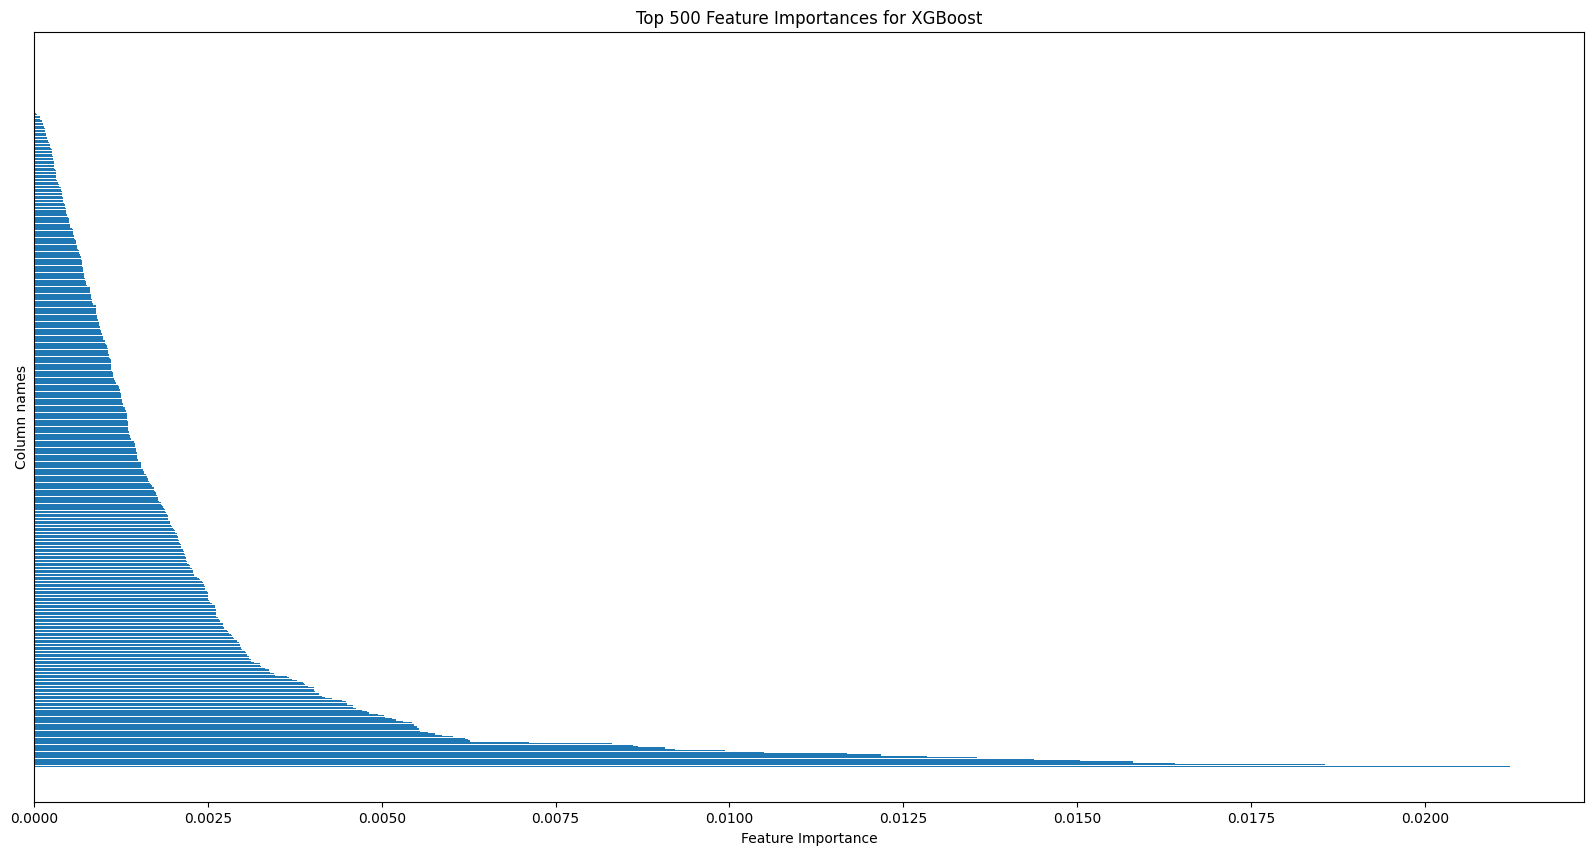

In [ ]:
top_n = 500
top_names = sorted_names[:top_n]
top_importance = importance[sorted_indices][:top_n]

plt.figure(figsize = (20,10))
plt.barh(top_names, top_importance, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Column names')
plt.title('Top 500 Feature Importances for XGBoost')
plt.yticks([])
plt.savefig('top_500_train.png')
plt.show()

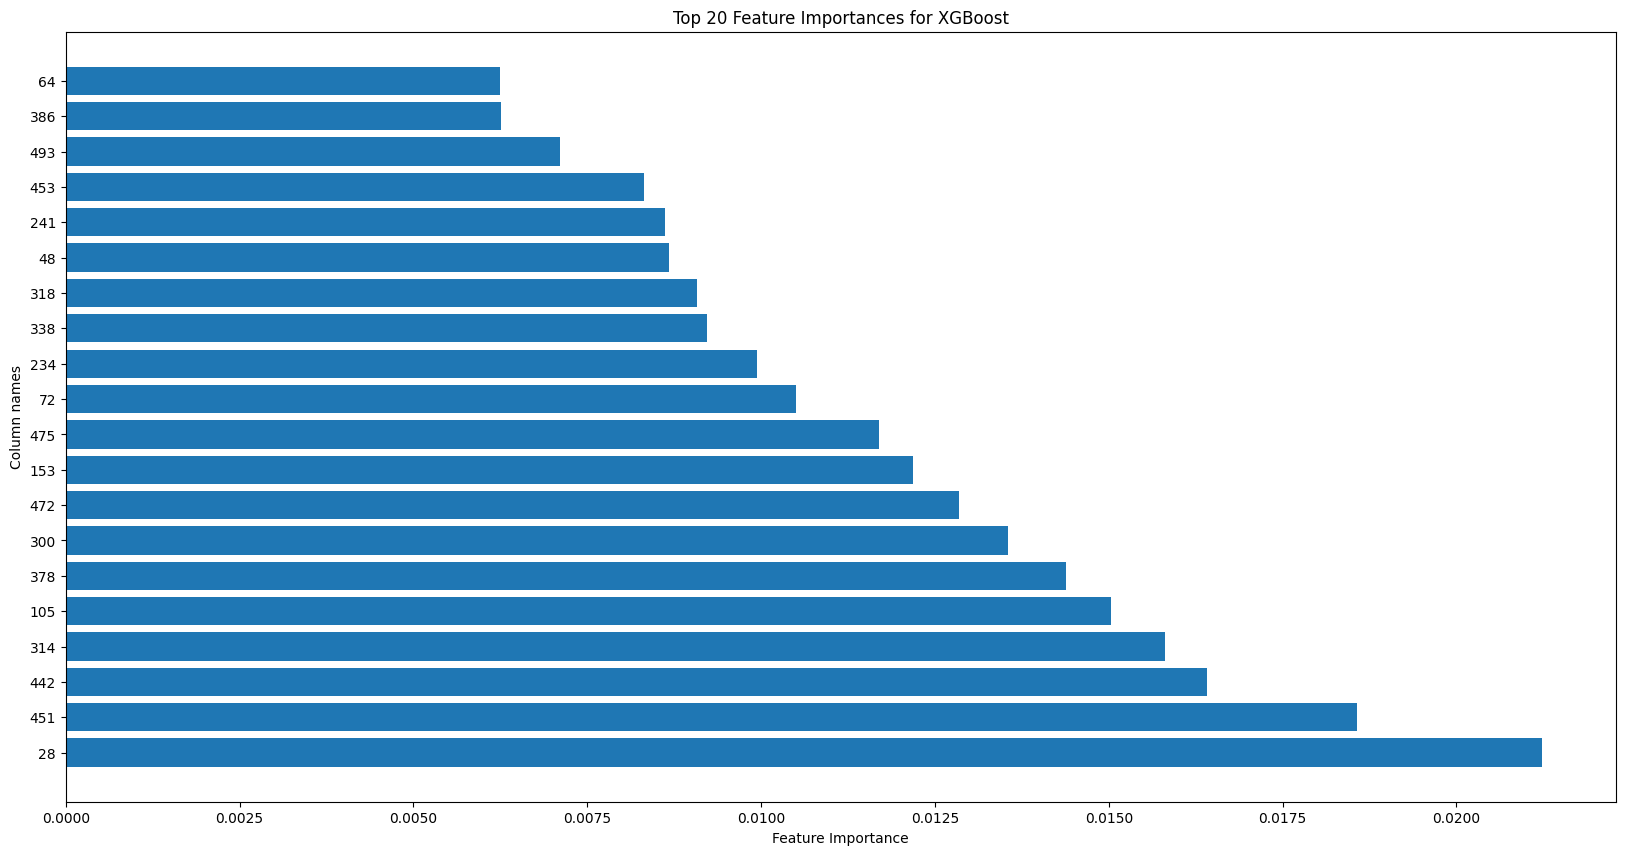

In [ ]:
top_n = 20
top_names = sorted_names[:top_n]
top_importance = importance[sorted_indices][:top_n]

plt.figure(figsize = (20,10))
plt.barh(top_names, top_importance, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Column names')
plt.title('Top 20 Feature Importances for XGBoost')
# plt.yticks([])
plt.savefig('top_20_train.png')
plt.show()

Wypisanie najmniejszej i największej liczby unikatowych wartości znalezionych w zmiennych

In [ ]:
# unikatowe wartości
unique_values = list()
for col in X.columns:
  n_unique = len(np.unique(X[col].values))
  unique_values.append(n_unique)
unique_values.sort()
print(unique_values[0])
print(unique_values[-1])

5
552


Wykres liczby unikatowych wartości w danych

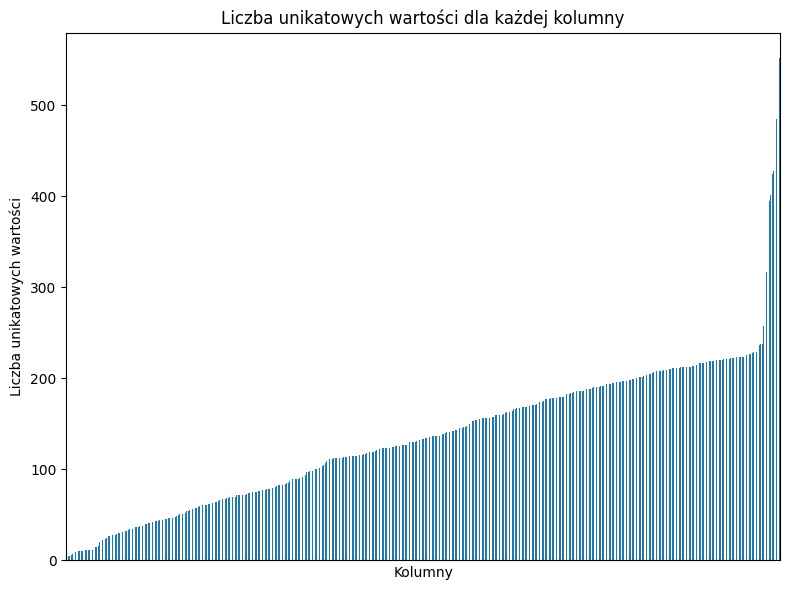

In [ ]:
unikalne_wartosci = X.nunique().sort_values()

# Tworzenie wykresu słupkowego z wartościami rosnącymi
plt.figure(figsize=(8, 6))
unikalne_wartosci.plot(kind='bar')
plt.xlabel('Kolumny')
plt.ylabel('Liczba unikatowych wartości')
plt.title('Liczba unikatowych wartości dla każdej kolumny')
plt.xticks([])
plt.tight_layout()
plt.show()

W obawie przed zmiennymi z jedną unikatową zmienną, sprawdzono jak pod tym kątem wyglądają dane. Minimalną liczbą unikatowych wartości jest 5, co nie ma podstaw na wskazanie błędu w danych. Brak interpretowalności zmiennych wpływa na decyzję o pozostawieniu danych w obecnym formacie bez usuwania kolumn.

Sprawdzenie liczbę zer, które często są problematyczne w danych (zdarza się, że zastępują braki danych).

In [ ]:
c_zeros = np.zeros(len(X_train.columns))
for i in range(len(X_train.columns)):
  c_zeros[i]=sum(X_train.iloc[:,i]==0)
data = {'column name': X_train.columns,
        'number of zeros': [val for val in c_zeros]}
pd.DataFrame(data).head().sort_values('number of zeros', ascending=False)

,column name,number of zeros
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


Nie wykryto kolumn z zerami. Problem został sprawdzony, a analiza poprowadzona dalej.

## **XGBoost przed standaryzacją oraz z wartościami odstającymi**

In [ ]:
XGB = XGBClassifier(random_state=3927)
XGB.fit(X_train, y_train)
print(balanced_accuracy_score(y_val, XGB.predict(X_val)))

0.7949999999999999


## **Wartości odstające**

Sprawdzenie wartości odstających w danych treningowych, które zostały wybrane poniżej 0.03 i powyżej 0.97 kwantyla oraz odpowiednio nimi zastąpione.

In [ ]:
train_quantiles = X_train.quantile([0.03, 0.97])

Funkcja do zastępowania outlierów.

In [ ]:
def replace_outliers(column):
    col_quantiles = train_quantiles.loc[:, column.name]
    return column.apply(lambda value: col_quantiles.loc[0.03] if value < col_quantiles.loc[0.03] else (col_quantiles.loc[0.97] if value > col_quantiles.loc[0.97] else value))

Stworzenie nowych ramek danych z wymienionymi outlierami.

In [ ]:
X_train_replaced = X_train.apply(replace_outliers, axis=0)

Sprawdzenie outlierów. Poniżej funkcja, która je zwraca:

In [ ]:
def find_outliers(col):
    lower_bound = col.quantile(0.03)
    upper_bound = col.quantile(0.97)

    return col[(col < lower_bound) | (col > upper_bound)]

In [ ]:
X_train_replaced_check = X_train.apply(find_outliers, axis=0)

Dataframe z pozostawionymi polami, gdzie wystąpiły outliery.

In [ ]:
X_train_replaced_check.dropna(how='all')

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,402.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,598.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,496.0,NaN,NaN,NaN,NaN,NaN,595.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,582.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,NaN,NaN,NaN,NaN,NaN,461.0,NaN,NaN,518.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,NaN,NaN,631.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,750.0,NaN,NaN,NaN,NaN,NaN,NaN


Sprawdzenie maksymalnej liczby występujących outlierów.

In [ ]:
not_nan_values = int(X_train_replaced_check.count().idxmax())

In [ ]:
not_nan_values

80

In [ ]:
type(not_nan_values)

int

Stworzenie nowej ramki danych składającej się z samych outlierów.

In [ ]:
X_train_outliers = pd.DataFrame()
for column in X_train_replaced_check.columns:
  non_nan_values = X_train_replaced_check[column][~X_train_replaced_check[column].isnull()]
  nan_values_needed = not_nan_values - len(non_nan_values)

  if nan_values_needed > 0:
      nan_values = [np.nan] * nan_values_needed
      new_column_values = list(non_nan_values) + nan_values
  else:
      new_column_values = list(non_nan_values)[:not_nan_values]

  X_train_outliers[column] = new_column_values

<ipython-input-20-10584be9e18b>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_outliers[column] = new_column_values
<ipython-input-20-10584be9e18b>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train_outliers[column] = new_column_values
<ipython-input-20-10584be9e18b>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

In [ ]:
X_train_outliers

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,496.0,425.0,598.0,463.0,416.0,464.0,402.0,480.0,528.0,463.0,...,536.0,470.0,541.0,732.0,562.0,414.0,466.0,515.0,582.0,569.0
1,466.0,556.0,428.0,512.0,602.0,494.0,595.0,473.0,525.0,464.0,...,525.0,490.0,422.0,207.0,575.0,582.0,466.0,510.0,581.0,439.0
2,469.0,546.0,422.0,501.0,420.0,465.0,569.0,481.0,457.0,464.0,...,437.0,489.0,438.0,758.0,577.0,431.0,499.0,454.0,421.0,545.0
3,498.0,551.0,609.0,504.0,418.0,465.0,398.0,480.0,519.0,500.0,...,443.0,490.0,427.0,174.0,421.0,582.0,465.0,510.0,589.0,550.0
4,467.0,386.0,411.0,461.0,383.0,498.0,354.0,473.0,458.0,464.0,...,433.0,490.0,429.0,820.0,571.0,599.0,493.0,529.0,579.0,547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,469.0,415.0,594.0,506.0,585.0,464.0,401.0,NaN,522.0,494.0,...,444.0,487.0,438.0,726.0,427.0,434.0,492.0,452.0,430.0,431.0
76,500.0,551.0,434.0,463.0,606.0,463.0,372.0,NaN,457.0,495.0,...,525.0,491.0,428.0,757.0,561.0,436.0,463.0,511.0,421.0,558.0
77,468.0,544.0,593.0,465.0,583.0,465.0,572.0,NaN,522.0,460.0,...,444.0,487.0,556.0,251.0,397.0,614.0,460.0,449.0,370.0,541.0
78,469.0,543.0,430.0,461.0,419.0,499.0,602.0,NaN,519.0,493.0,...,526.0,497.0,428.0,746.0,563.0,602.0,461.0,521.0,410.0,436.0


W początkowych eksperymentach wybrano 70% danych do treningu i 30% danych do walidacji. Wówczas występowało jedynie do 10 outlierów, a obecnie jest ich do 80.

Autorki ze względu na to jak liczby się zmieniły, postanowiły sprawdzić modele w przypadku danych z outlierami oraz bez nich, co może w niewielkim stopniu przyczynić się do poprawy jakości modelu.

Użyta praktyka jest typowa w analizie danych, jednakże w tym projekcie natknięto się na specyficzny przypadek danych, ponieważ są sztucznie wygenerowane.

Poniżej zawarty jest zakomentowany kod, który służy do wypełniania braków danych. W naszym przypadku nie jest to potrzebne, ale postanowiono, że kod zostanie na rzecz dalszych projektów.

In [ ]:
# imputer_num = SimpleImputer(strategy='median')
# imputer_num.fit(X_train_replaced)

# X_train_imputed = imputer_num.transform(X_train_replaced)
# X_val_imputed = imputer_num.transform(X_val_replaced)
# X_test_imputed = imputer_num.transform(X_test_replaced)
# X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train_replaced.columns)
# X_val_imputed = pd.DataFrame(X_val_imputed, columns=X_val_replaced.columns)
# X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test_replaced.columns)

## **Standaryzacja danych bez wartości odstających**

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_replaced)

X_train_ss_outliers = scaler.transform(X_train_replaced)
X_val_ss_outliers = scaler.transform(X_val)
X_test_ss_outliers = scaler.transform(X_test)
X_train_ss_outliers = pd.DataFrame(X_train_ss_outliers, columns=X_train_replaced.columns)
X_val_ss_outliers = pd.DataFrame(X_val_ss_outliers, columns=X_val.columns)
X_test_ss_outliers = pd.DataFrame(X_test_ss_outliers, columns=X_test.columns)

## **Standaryzacja danych z wartościami odstającymi**

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_ss = scaler.transform(X_train)
X_val_ss = scaler.transform(X_val)
X_test_ss = scaler.transform(X_test)
X_train_ss = pd.DataFrame(X_train_ss, columns=X_train.columns)
X_val_ss = pd.DataFrame(X_val_ss, columns=X_val.columns)
X_test_ss = pd.DataFrame(X_test_ss, columns=X_test.columns)

## **XGBoost ze standaryzacją i BayesSearchCV, ale bez wartości odstających**

In [ ]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=3927)

params = {
    'max_depth': (4, 10),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'n_estimators': (100, 10000),
    'gamma': (0, 1.0),
    'min_child_weight': (1, 10)
}

xgboost_model = XGBClassifier(random_state=3927)
opt = BayesSearchCV(xgboost_model, params, n_iter=100, cv=cv_strategy, verbose=1, random_state=3927, scoring='balanced_accuracy')
_ = opt.fit(X_train_ss_outliers, y_train)

# Get the best parameters
best_params = opt.best_params_
print("Best Parameters:", best_params)
bs_results = opt.cv_results_

In [ ]:
best_xgb_bayes = opt.best_estimator_
print(balanced_accuracy_score(y_val, best_xgb_bayes.predict(X_val_ss_outliers)))

## **Badanie korelacji**

In [ ]:
X_train_ss.corr()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,0.041984,-0.018941,0.025121,-0.001902,0.026513,0.033793,0.052551,-0.018694,-0.013265,...,-0.013377,0.018533,-0.011286,0.003158,0.013832,-0.033439,0.018476,-0.021842,0.015505,-0.048879
1,0.041984,1.000000,-0.013885,0.021776,0.024676,-0.023752,-0.031181,0.028754,0.018331,-0.014334,...,0.035191,0.000244,0.010703,0.030302,-0.009429,0.026875,0.043852,-0.020179,0.006975,0.035104
2,-0.018941,-0.013885,1.000000,-0.005328,0.000439,0.014213,0.005299,-0.020377,-0.010768,-0.021449,...,-0.000047,-0.001557,-0.002885,-0.018237,0.003017,0.025538,0.016790,0.053440,0.004976,0.020293
3,0.025121,0.021776,-0.005328,1.000000,-0.012660,0.045960,-0.009488,-0.030681,-0.026108,0.016324,...,0.004871,-0.041120,-0.021811,0.028662,-0.015419,0.011538,-0.016048,-0.004183,-0.007349,-0.006539
4,-0.001902,0.024676,0.000439,-0.012660,1.000000,0.002316,0.008023,0.018746,-0.065385,-0.028754,...,-0.016316,0.004231,-0.024844,-0.016661,0.037129,0.027961,0.047593,0.020236,0.017915,0.007604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.033439,0.026875,0.025538,0.011538,0.027961,0.012354,0.008902,0.008002,-0.008398,-0.018429,...,0.000173,-0.036132,-0.026665,0.004500,0.056654,1.000000,-0.009351,-0.016520,-0.034855,-0.018834
496,0.018476,0.043852,0.016790,-0.016048,0.047593,0.003263,0.029235,0.020526,-0.027598,0.078199,...,-0.014675,-0.017585,-0.001938,-0.034910,-0.006308,-0.009351,1.000000,-0.004397,0.004734,-0.006446
497,-0.021842,-0.020179,0.053440,-0.004183,0.020236,0.020034,-0.034057,0.004391,-0.012964,-0.012743,...,0.005206,-0.018237,0.008195,-0.034894,-0.029646,-0.016520,-0.004397,1.000000,-0.003120,0.030360
498,0.015505,0.006975,0.004976,-0.007349,0.017915,-0.019645,0.030091,0.006292,0.019008,-0.000670,...,-0.014387,-0.024798,0.007488,0.033207,-0.002698,-0.034855,0.004734,-0.003120,1.000000,0.003731


Sprawdzenie skorelowanych kolumn od progu 80%.

In [ ]:
# korelacja na poziomie 80%
corr_size = 0.8
c = X_train_ss.iloc[:,:-1].corr().abs()

mask = np.triu(np.ones(c.shape), k=1).astype(bool)
s = c.where(mask).unstack()

result = s[np.abs(s) >= corr_size].sort_values(ascending=False)
print(result.to_string())

336  64     0.990444
472  442    0.990211
475  241    0.989739
318  28     0.989734
128  105    0.989396
451  28     0.989281
433  153    0.989235
     281    0.988931
451  318    0.988893
281  153    0.988535
378  48     0.988467
493  453    0.988457


Wyrzucenie skorelowanych kolumn przed PCA czy Lasso znacznie osłabiało predykcję modelu. Zadecydowano o pozostawieniu tego problemu oraz przekazaniu go wspomnainym metodom (Lasso wykrywa korelacje, a PCA przekształca dane w nieskorelowane kobminacje zmiennych).

## **Lasso/Ridge**

Sprawdzenie współczynników regularyzacji metodą Lasso i Ridge przy wybranych (dość standardowych) współczynnikach alpha.

Pomaga to w selekcji zmiennych przed decyzją związaną z silnie skorelowanymi kolumnami. Tak jak wspomniano, zrezygnowano z "ręcznego" usuwania wysoce skorelowanych zmiennych.

In [ ]:
# Lasso
lasso = Lasso(alpha=0.1)
# Alpha im większa tym bardziej cechy są ustawiane na zero
lasso.fit(X_train_ss, y_train)
lasso_coefs = pd.Series(lasso.coef_, index=X_train_ss.columns)

# Ridge
ridge = Ridge(alpha=1.0)
# Alpha im większa tym bardziej współczynniki są "zredukowane"
ridge.fit(X_train_ss, y_train)
ridge_coefs = pd.Series(ridge.coef_, index=X_train_ss.columns)

print("Współczynniki Lasso:")
print(lasso_coefs)

print("\nWspółczynniki Ridge:")
print(ridge_coefs)

Współczynniki Lasso:
0      0.0
1      0.0
2      0.0
3     -0.0
4      0.0
      ... 
495    0.0
496   -0.0
497    0.0
498    0.0
499   -0.0
Length: 500, dtype: float64

Współczynniki Ridge:
0      0.000230
1      0.018271
2      0.008973
3      0.005102
4      0.016581
         ...   
495   -0.016018
496   -0.028537
497    0.020581
498    0.011447
499   -0.001661
Length: 500, dtype: float64


In [ ]:
# Korelacja po Lasso
lasso_features = lasso_coefs[lasso_coefs != 0].index.tolist()
df_lasso = X_train_ss[lasso_features]
correlation_matrix_lasso = df_lasso.corr()

# Korelacja po Ridge
ridge_features = ridge_coefs.index.tolist()
df_ridge = X_train_ss[ridge_features]
correlation_matrix_ridge = df_ridge.corr()

print("\nMacierz korelacji po zastosowaniu Lasso:")
print(correlation_matrix_lasso)

print("\nMacierz korelacji po zastosowaniu Ridge:")
print(correlation_matrix_ridge)


Macierz korelacji po zastosowaniu Lasso:
     475
475  1.0

Macierz korelacji po zastosowaniu Ridge:
            0         1         2         3         4         5         6  \
0    1.000000  0.041984 -0.018941  0.025121 -0.001902  0.026513  0.033793   
1    0.041984  1.000000 -0.013885  0.021776  0.024676 -0.023752 -0.031181   
2   -0.018941 -0.013885  1.000000 -0.005328  0.000439  0.014213  0.005299   
3    0.025121  0.021776 -0.005328  1.000000 -0.012660  0.045960 -0.009488   
4   -0.001902  0.024676  0.000439 -0.012660  1.000000  0.002316  0.008023   
..        ...       ...       ...       ...       ...       ...       ...   
495 -0.033439  0.026875  0.025538  0.011538  0.027961  0.012354  0.008902   
496  0.018476  0.043852  0.016790 -0.016048  0.047593  0.003263  0.029235   
497 -0.021842 -0.020179  0.053440 -0.004183  0.020236  0.020034 -0.034057   
498  0.015505  0.006975  0.004976 -0.007349  0.017915 -0.019645  0.030091   
499 -0.048879  0.035104  0.020293 -0.006539  0.0076

## **Lasso z optymalnym parametrem alpha bez wartości odstających**

In [ ]:
lasso_cv = LassoCV(cv=8, random_state=3927)
lasso_cv.fit(X_train_ss_outliers, y_train)

LassoCV(cv=8, random_state=3927)

In [ ]:
optimal_alpha = lasso_cv.alpha_
print("Optymalna alpha wybrana przez LassoCV:", optimal_alpha)

Optymalna alpha wybrana przez LassoCV: 0.032218728562936595


In [ ]:
# Lasso
lasso = Lasso(alpha=optimal_alpha)
# Alpha im większa tym bardziej cechy są ustawiane na zero
lasso.fit(X_train_ss_outliers, y_train)
lasso_coefs = pd.Series(lasso.coef_, index=X_train_ss_outliers.columns)

print("Współczynniki Lasso:")
print(lasso_coefs)

# Korelacja po Lasso
lasso_features_outliers = lasso_coefs[lasso_coefs != 0].index.tolist()
df_lasso = X_train_ss_outliers[lasso_features_outliers]
correlation_matrix_lasso = df_lasso.corr()

print("\nMacierz korelacji po zastosowaniu Lasso:")
print(correlation_matrix_lasso)

Współczynniki Lasso:
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
495   -0.0
496   -0.0
497    0.0
498    0.0
499    0.0
Length: 500, dtype: float64

Macierz korelacji po zastosowaniu Lasso:
           48       241       424       475
48   1.000000  0.013172 -0.026861  0.015233
241  0.013172  1.000000 -0.028179  0.991615
424 -0.026861 -0.028179  1.000000 -0.023631
475  0.015233  0.991615 -0.023631  1.000000


Transformacja zmiennych na podstawie Lasso

In [ ]:
X_train_lasso_outliers = X_train_ss_outliers[lasso_features_outliers]
X_val_lasso_outliers = X_val_ss_outliers[lasso_features_outliers]
X_test_lasso_outliers = X_test_ss_outliers[lasso_features_outliers]

# **XGBoost z Lasso**

Badanie istotności zmiennych za pomocą atrybutu metody XGBoost.

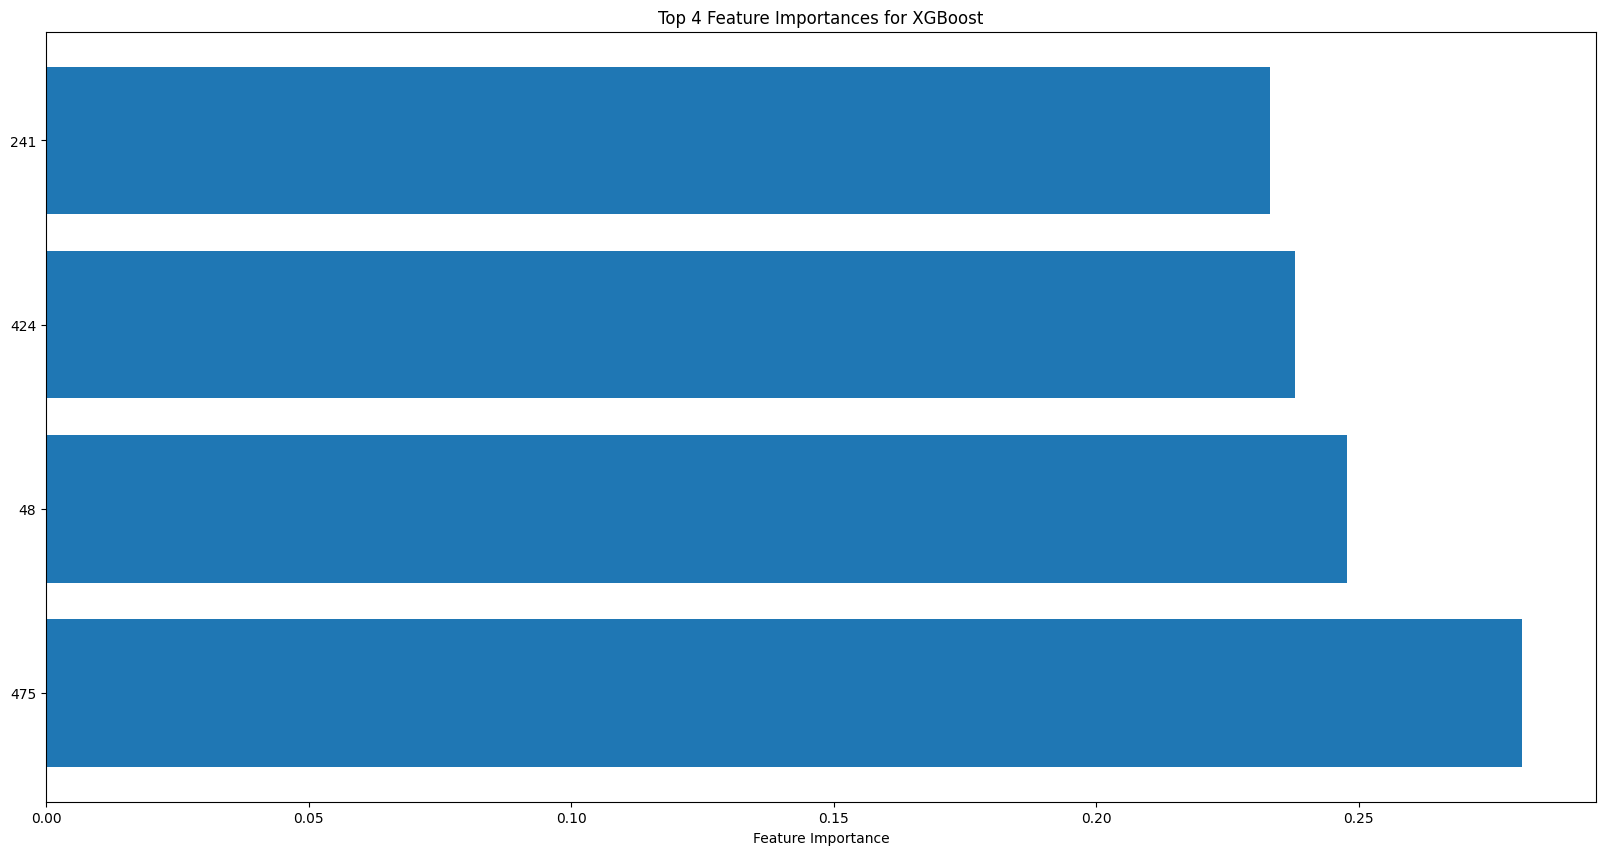

In [ ]:
XGB = XGBClassifier(reg_lambda=optimal_alpha, random_state=3927)
XGB.fit(X_train_lasso_outliers, y_train)

importance = XGB.feature_importances_
feature_names = list(X_train_lasso_outliers.columns)

sorted_indices = np.argsort(importance)[::-1]
sorted_names = [feature_names[i] for i in sorted_indices]

top_n = 4
top_names = sorted_names[:top_n]
top_importance = importance[sorted_indices][:top_n]

plt.figure(figsize = (20,10))
plt.barh(top_names, top_importance, align='center')
plt.xlabel('Feature Importance')
plt.title('Top 4 Feature Importances for XGBoost')
plt.show()

## **XGBoost z Lasso oraz BayesSearchCV**

Kroswalidacja bayesowska, aby dobrać odpowiednie parametry w metodzie XGBoost. Wykonywana jest ona na zbiorze przekształconym wcześniej przez metodę Lasso.

In [ ]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=3927)

params = {
    'max_depth': (4, 10),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'n_estimators': (100, 10000),
    'gamma': (0, 1.0),
    'min_child_weight': (1, 10)
}

xgboost_model = XGBClassifier(random_state=3927)
opt = BayesSearchCV(xgboost_model, params, n_iter=100, cv=cv_strategy, verbose=1, random_state=3927, scoring='balanced_accuracy')
_ = opt.fit(X_train_lasso_outliers, y_train)

# Get the best parameters
best_params = opt.best_params_
print("Best Parameters:", best_params)
#print(opt.score(X_train_lasso, y_train))
bs_results= opt.cv_results_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Sprawdzenie jakości modelu zbudowanego na podstawie danych przekształconych przez Lasso.

In [ ]:
best_xgb_model = opt.best_estimator_
# best_xgb_model.score(X_val_lasso,y_val)
print(balanced_accuracy_score(y_val, best_xgb_model.predict(X_val_lasso_outliers)))

0.635


## **XGBoost z Lasso bez BayesSearchCV**

In [ ]:
XGB = XGBClassifier(random_state=3927)
XGB.fit(X_train_lasso_outliers, y_train)
print(balanced_accuracy_score(y_val, XGB.predict(X_val_lasso_outliers)))

0.62


Ze względu na to, że w tym przypadku osiągnięto najmniejszy wynik, to sprawdzono (z ciekawości) jakie zmienne i jak bardzo wpływają na model.

SHAP

In [ ]:
explainer = shap.TreeExplainer(XGB, X_train_lasso_outliers)
shap_values = explainer(X_train_lasso_outliers)

[16:57:11] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 1782/1800 [00:13<00:00]       

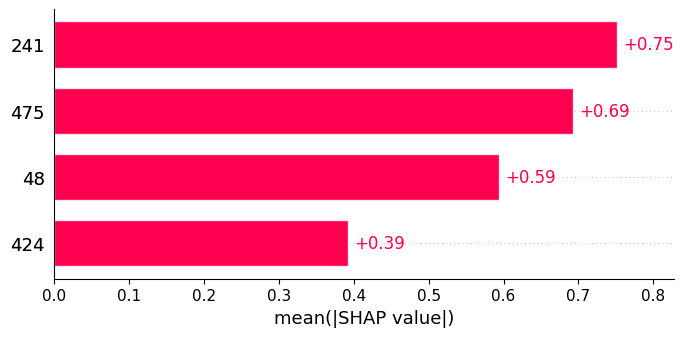

In [ ]:
# Najbardziej wpływowa kolumna: 241
shap.plots.bar(shap_values)

Dodatkowo sprawdzono jak to wyglądało w przypadku, gdy model był niewiele lepszy dzięki BayesSearchCV.

In [ ]:
explainer_2 = shap.TreeExplainer(best_xgb_model, X_train_lasso_outliers)
shap_values_2 = explainer_2(X_train_lasso_outliers)

[17:12:38] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


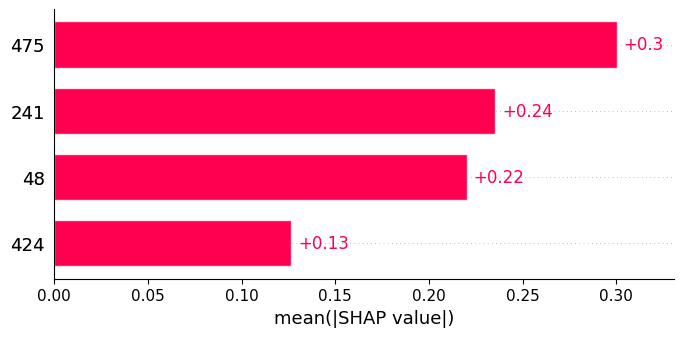

In [ ]:
# Najbardziej wpływowa kolumna: 241
shap.plots.bar(shap_values_2)

# **XGBoost z PCA**

Autorki podjęły decyzję o zastosowaniu metody PCA dla bardzo małej liczby komponentów głównych. Decyzja ta została podjęta na podstawe wartości wyjaśnionej zmienności przez kolejne zmienne w modelu.

## **PCA z wartościami odstającymi**

In [ ]:
pca = PCA(n_components=5, random_state=3927)
pca.fit(X_train_ss)
print(pca.explained_variance_ratio_)

X_train_pca = pca.transform(X_train_ss)
X_val_pca = pca.transform(X_val_ss)
X_test_pca = pca.transform(X_test_ss)
X_train_pca = pd.DataFrame(X_train_pca)
X_val_pca = pd.DataFrame(X_val_pca)
X_test_pca = pd.DataFrame(X_test_pca)

[0.01291692 0.01008636 0.00883976 0.00637539 0.00508178]


In [ ]:
XGB = XGBClassifier(random_state=3927)
XGB.fit(X_train_pca, y_train)
print(balanced_accuracy_score(y_val, XGB.predict(X_val_pca)))

0.81


## **PCA bez wartości odstających**

In [ ]:
pca_outliers = PCA(n_components=5, random_state=3927)
pca_outliers.fit(X_train_ss_outliers)
print(pca_outliers.explained_variance_ratio_)

X_train_pca_outliers = pca_outliers.transform(X_train_ss_outliers)
X_val_pca_outliers = pca_outliers.transform(X_val_ss_outliers)
X_test_pca_outliers = pca_outliers.transform(X_test_ss_outliers)
X_train_pca_outliers = pd.DataFrame(X_train_pca_outliers)
X_val_pca_outliers = pd.DataFrame(X_val_pca_outliers)
X_test_pca_outliers = pd.DataFrame(X_test_pca_outliers)

[0.01291557 0.01006103 0.00886495 0.00635201 0.00513545]


In [ ]:
XGB = XGBClassifier(random_state=3927)
XGB.fit(X_train_pca_outliers, y_train)
print(balanced_accuracy_score(y_val, XGB.predict(X_val_pca_outliers)))

0.815


## **PCA z BayesSearchCV oraz wartościami odstającymi**

Kroswalidacja bayesowska, aby dobrać odpowiednie parametry w metodzie XGBoost. Wykonywana jest ona na zbiorze przekształconym wcześniej przez metodę PCA.

In [ ]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=3927)

params = {
    'max_depth': (4, 10),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'n_estimators': (100, 10000),
    'gamma': (0, 1.0),
    'min_child_weight': (1, 10)
}

xgboost_model = XGBClassifier(random_state=3927)
opt = BayesSearchCV(xgboost_model, params, n_iter=100, cv=cv_strategy, verbose=1, random_state=3927, scoring='balanced_accuracy')
_ = opt.fit(X_train_pca, y_train)

# Get the best parameters
best_params = opt.best_params_
print("Best Parameters:", best_params)
# print(opt.score(X_train_pca, y_train))
bs_results = opt.cv_results_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: OrderedDict([('gamma', 0.05232775913710

In [ ]:
best_xgb_pca = opt.best_estimator_
print(balanced_accuracy_score(y_val, best_xgb_pca.predict(X_val_pca)))

0.84


In [ ]:
pd.Series(
    best_xgb_pca.predict_proba(X_test_pca)[:,1],
    name='\'297156_313480\''
).to_csv("output_pca_table7.txt", index=False)

ROC

In [ ]:
best_xgb_model = XGBClassifier(**best_params, random_state=3927)
best_xgb_model.fit(X_train_pca, y_train)
y_pred = best_xgb_model.predict(X_val_pca)
y_pred_proba = best_xgb_model.predict_proba(X_val_pca)[:, 1]

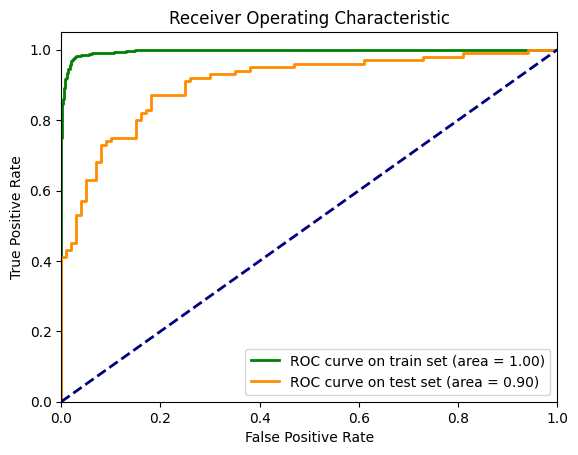

In [ ]:
y_pred2 = best_xgb_model.predict(X_train_pca)
y_pred_proba2 = best_xgb_model.predict_proba(X_train_pca)[:, 1]

fpr, tpr, _ = roc_curve(y_train, y_pred_proba2)
roc_auc = sklearn_auc(fpr, tpr)
fpr_test, tpr_test, _ = roc_curve(y_val, y_pred_proba)
roc_auc_test = sklearn_auc(fpr_test, tpr_test)
plt.figure()
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve on train set (area = %0.2f)' % roc_auc)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='ROC curve on test set (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc.png')
plt.show()

## **PCA z BayesSearchCV oraz bez wartości odstających**

Kroswalidacja bayesowska, aby dobrać odpowiednie parametry w metodzie XGBoost. Wykonywana jest ona na zbiorze przekształconym wcześniej przez metodę PCA.

In [ ]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=3927)

params = {
    'max_depth': (4, 10),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'n_estimators': (100, 10000),
    'gamma': (0, 1.0),
    'min_child_weight': (1, 10)
}

xgboost_model = XGBClassifier(random_state=3927)
opt = BayesSearchCV(xgboost_model, params, n_iter=100, cv=cv_strategy, verbose=1, random_state=3927, scoring='balanced_accuracy')
_ = opt.fit(X_train_pca_outliers, y_train)

# Get the best parameters
best_params = opt.best_params_
print("Best Parameters:", best_params)
# print(opt.score(X_train_pca, y_train))
bs_results = opt.cv_results_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
best_xgb_pca_outliers = opt.best_estimator_
print(balanced_accuracy_score(y_val, best_xgb_pca_outliers.predict(X_val_pca_outliers)))

0.825


In [ ]:
pd.Series(
    best_xgb_pca_outliers.predict_proba(X_test_pca_outliers)[:,1],
    name='\'297156_313480\''
).to_csv("297156_313480_artifical_model_prediction.txt", index=False)